https://deepctr-doc.readthedocs.io/en/latest/Examples.html#regression-movielens

In [1]:
import os

DIR_DATA = os.path.join(os.environ["HOME"], "workspace/third_party/shenweichen/DeepCTR/examples")

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

from deepctr.models import DeepFM
from deepctr.feature_column import SparseFeat, VarLenSparseFeat, get_feature_names

In [3]:
def split(x):
    key_ans = x.split('|')
    for key in key_ans:
        if key not in key2index:
            # Notice : input value 0 is a special "padding",so we do not use 0 to encode valid feature for sequence input
            key2index[key] = len(key2index) + 1
    return list(map(lambda x: key2index[x], key_ans))


In [4]:
data = pd.read_csv(os.path.join(DIR_DATA, "movielens_sample.txt"))

sparse_features = ["movie_id", "user_id", "gender", "age", "occupation", "zip"]
target = ['rating']

In [5]:
# 1.Label Encoding for sparse features,and process sequence features
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])

In [6]:
# preprocess the sequence feature

key2index = {}
genres_list = list(map(split, data['genres'].values))
genres_length = np.array(list(map(len, genres_list)))
max_len = max(genres_length)
# Notice : padding=`post`
genres_list = pad_sequences(genres_list, maxlen=max_len, padding='post', )


In [7]:
# 2.count #unique features for each sparse field and generate feature config for sequence feature

fixlen_feature_columns = [
    SparseFeat(feat, data[feat].max() + 1, embedding_dim=4)
    for feat in sparse_features
]

use_weighted_sequence = False
if use_weighted_sequence:
    varlen_feature_columns = [
        VarLenSparseFeat(
            SparseFeat('genres', vocabulary_size=len(key2index) + 1, embedding_dim=4),
            maxlen=max_len, combiner='mean',
            weight_name='genres_weight'
        )
    ]  # Notice : value 0 is for padding for sequence input feature
else:
    varlen_feature_columns = [
        VarLenSparseFeat(
            SparseFeat('genres', vocabulary_size=len(key2index) + 1, embedding_dim=4),
            maxlen=max_len, combiner='mean', weight_name=None
        )
    ]  # Notice : value 0 is for padding for sequence input feature

In [8]:
linear_feature_columns = fixlen_feature_columns + varlen_feature_columns
dnn_feature_columns = fixlen_feature_columns + varlen_feature_columns

In [9]:
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [10]:
# 3.generate input data for model
model_input = {name: data[name] for name in feature_names}  #
model_input["genres"] = genres_list
model_input["genres_weight"] = np.random.randn(data.shape[0], max_len, 1)

In [11]:
# 4.Define Model,compile and train
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression')

2022-09-24 20:56:57.423384: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
model.compile(
    "adam",
    "mse",
    metrics=['mse'],
)

In [13]:
history = model.fit(
    model_input,
    data[target].values,
    batch_size=256,
    epochs=10,
    verbose=2,
    validation_split=0.2,
)

Epoch 1/10


/Users/lxh/.virtualenv/alisa/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:587: UserWarning: Input dict contained keys ['genres_weight'] which did not match any model input. They will be ignored by the model.
  warnings.warn(


1/1 - 2s - loss: 14.3000 - mse: 14.3000 - val_loss: 13.3689 - val_mse: 13.3689
Epoch 2/10
1/1 - 0s - loss: 14.1453 - mse: 14.1453 - val_loss: 13.2167 - val_mse: 13.2167
Epoch 3/10
1/1 - 0s - loss: 13.9668 - mse: 13.9668 - val_loss: 13.0506 - val_mse: 13.0506
Epoch 4/10
1/1 - 0s - loss: 13.7731 - mse: 13.7731 - val_loss: 12.8710 - val_mse: 12.8710
Epoch 5/10
1/1 - 0s - loss: 13.5643 - mse: 13.5643 - val_loss: 12.6744 - val_mse: 12.6744
Epoch 6/10
1/1 - 0s - loss: 13.3360 - mse: 13.3360 - val_loss: 12.4587 - val_mse: 12.4587
Epoch 7/10
1/1 - 0s - loss: 13.0857 - mse: 13.0857 - val_loss: 12.2216 - val_mse: 12.2216
Epoch 8/10
1/1 - 0s - loss: 12.8117 - mse: 12.8117 - val_loss: 11.9612 - val_mse: 11.9612
Epoch 9/10
1/1 - 0s - loss: 12.5106 - mse: 12.5106 - val_loss: 11.6753 - val_mse: 11.6753
Epoch 10/10
1/1 - 0s - loss: 12.1804 - mse: 12.1804 - val_loss: 11.3614 - val_mse: 11.3614


In [14]:
history_df = pd.DataFrame(history.history)

<AxesSubplot:title={'center':'MSE'}>

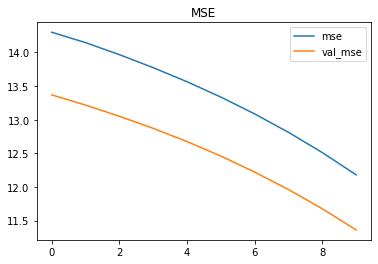

In [15]:
history_df.loc[:, ['mse', 'val_mse']].plot(title="MSE")